# Inference Test

### Load Dependencies

In [1]:
import torch, os, cv2
import run
import numpy as np
#import pandas as pd
import util.misc as misc
import torchvision.transforms.functional as TF
from PIL import Image
#import torch.nn.functional as F

/home/matteopierucci/anaconda3/envs/clipcount/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Inference to reproduce paper

In [2]:
SCALE_FACTOR = 60
model_ckpt = './ckpt/clipcount_pretrained.ckpt' # pre-trained model
model = run.Model.load_from_checkpoint(model_ckpt, strict=False)
model.eval()

Model(
  (model): CLIPCount(
    (clip): CLIP(
      (visual): VisionTransformer(
        (conv1): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16), bias=False)
        (ln_pre): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (transformer): Transformer(
          (resblocks): Sequential(
            (0): ResidualAttentionBlock(
              (attn): MultiheadAttention(
                (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
              )
              (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
              (mlp): Sequential(
                (c_fc): Linear(in_features=768, out_features=3072, bias=True)
                (gelu): QuickGELU()
                (c_proj): Linear(in_features=3072, out_features=768, bias=True)
              )
              (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
            )
            (1): ResidualAttentionBlock(
              (attn): MultiheadAttent

In [3]:
def infer(img, prompt):
    model.eval()
    model.model = model.model.cuda()
    with torch.no_grad():
        # reshape height to 384, keep aspect ratio
        img = torch.from_numpy(img).permute(2, 0, 1).unsqueeze(0).cuda()
        img = TF.resize(img, (384))
        
        img = img.float()/255.
        img = torch.clamp(img, 0, 1)
        prompt = [prompt]
        
        with torch.cuda.amp.autocast():
            raw_h, raw_w = img.shape[2:]
            patches, _ = misc.sliding_window(img,stride=128)
            #covert to batch
            patches = torch.from_numpy(patches).float().to(img.device)
            prompt = np.repeat(prompt, patches.shape[0], axis=0)
            output = model.forward(patches, prompt)
            output.unsqueeze_(1)
            output = misc.window_composite(output, stride=128)
            output = output.squeeze(1)
            #crop to original width
            output = output[:, :, :raw_w]
        
        pred_cnt = torch.sum(output[0]/SCALE_FACTOR).item()
        pred_density = output[0].detach().cpu().numpy()
        # normalize
        pred_density = pred_density/pred_density.max()
        pred_density_write = 1. - pred_density
        pred_density_write = cv2.applyColorMap(np.uint8(255*pred_density_write), cv2.COLORMAP_JET)
        pred_density_write = pred_density_write/255.
        # pred_rgb = cv2.applyColorMap(np.uint8(255*pred_density), cv2.COLORMAP_JET)
        img = img.squeeze(0).permute(1, 2, 0).detach().cpu().numpy()

        
        heatmap_pred = 0.33 * img + 0.67 * pred_density_write
        heatmap_pred = heatmap_pred/heatmap_pred.max()
    return heatmap_pred, pred_cnt

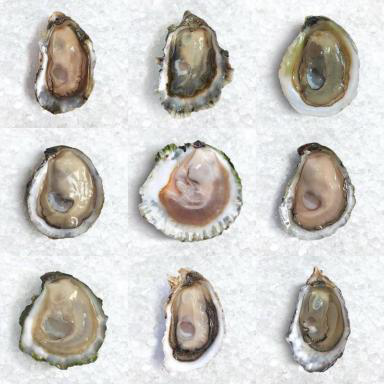

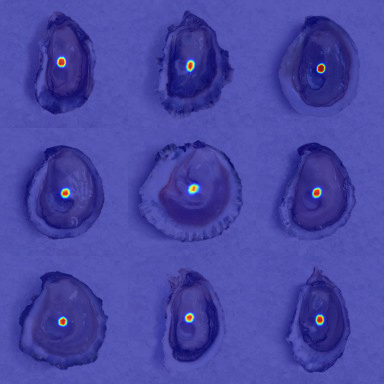

Prediction count: 11.03125


In [4]:
img_directory = './data/FSC/images_384_VarV2'
img_filename =  '271.jpg'
#img_filename =  '5918.jpg'

img = Image.open(os.path.join(img_directory, img_filename))
img_array = np.array(img)
prompt = "oysters"
#prompt = "eggs"

heatmap, cnt = infer(img_array, prompt)
res = Image.fromarray(np.uint8(255*heatmap))

img.show()
res.show()
print(f'Prediction count: {cnt}')

### Replicate paper results

In [4]:
import os, json
import pandas as pd
import tqdm
import matplotlib.pyplot as plt

In [5]:
data_dir = "./data/FSC/FSC_147"
split_classes_file = "Split_Classes_FSC147.json"
split_images_file = "Train_Test_Val_FSC_147.json"
gt_json_filename = "gt_cnts_FSC147.json"

img_class_txt = "ImageClasses_FSC147.txt"
            
with open(os.path.join(data_dir, split_classes_file), 'r') as f:
    split_classes = json.load(f)

with open(os.path.join(data_dir, split_images_file), 'r') as f:
    split_images = json.load(f)    

# importing GT Counts JSON
with open(os.path.join(data_dir, gt_json_filename), 'r') as file:
    gt_counts_dict = json.load(file)
    
img_classes = {}

with open(os.path.join(data_dir, img_class_txt), 'r') as file:
    for line in file:
        line = line.strip().split('\t')
        if len(line) == 2:
            img_name, label = line
            img_classes[img_name] = label

    
df = pd.DataFrame([], columns=split_classes["test"], index=split_images["test"])

In [15]:
img_directory = './data/FSC/images_384_VarV2'


cnt_errors = 0
normalized_cnt_errors = 0
normalized_squared_error = 0
squared_errors = []
relative_errors = []
gt_counts = []
squared_errors_copy = []

for img_filename in tqdm.tqdm(split_images["test"]):
    
    img = Image.open(os.path.join(img_directory, img_filename))
    img.load()
    img_array = np.array(img)
    
    prompt = img_classes[img_filename]
    _, pred_cnt= infer(img_array, prompt)
    
    cnt_error = abs(pred_cnt - gt_counts_dict[img_filename])
    cnt_errors += cnt_error
    normalized_cnt_errors += (cnt_error/gt_counts_dict[img_filename])
    squared_error = cnt_error ** 2
    #squared_gt_cnt = (gt_counts_dict[img_filename])**2
    normalized_squared_error += (squared_error/gt_counts_dict[img_filename])
    squared_errors.append(squared_error)
    if (cnt_error/gt_counts_dict[img_filename])<3 and gt_counts_dict[img_filename]<500 and squared_error < 60000:
        relative_errors.append(cnt_error/gt_counts_dict[img_filename])
        gt_counts.append(gt_counts_dict[img_filename])
        squared_errors_copy.append(squared_error)
    

mae = cnt_errors/len(split_images["test"])
mse = np.mean(squared_errors)
rmse = np.sqrt(mse)
nae = normalized_cnt_errors/len(split_images["test"])
sre = np.sqrt(normalized_squared_error/len(split_images["test"]))

print("Mean Absolute Error (MAE):", mae)
#print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)
print("Normalized Absolute Error (NAE):", nae)
print("Squared Relative Error(SRE):", sre)

100%|██████████| 1190/1190 [03:09<00:00,  6.29it/s]

Mean Absolute Error (MAE): 17.364147846638655
Root Mean Squared Error (RMSE): 105.23474425649962
Normalized Absolute Error (NAE): 0.4095311693179643
Squared Relative Error(SRE): 11.236102958792706


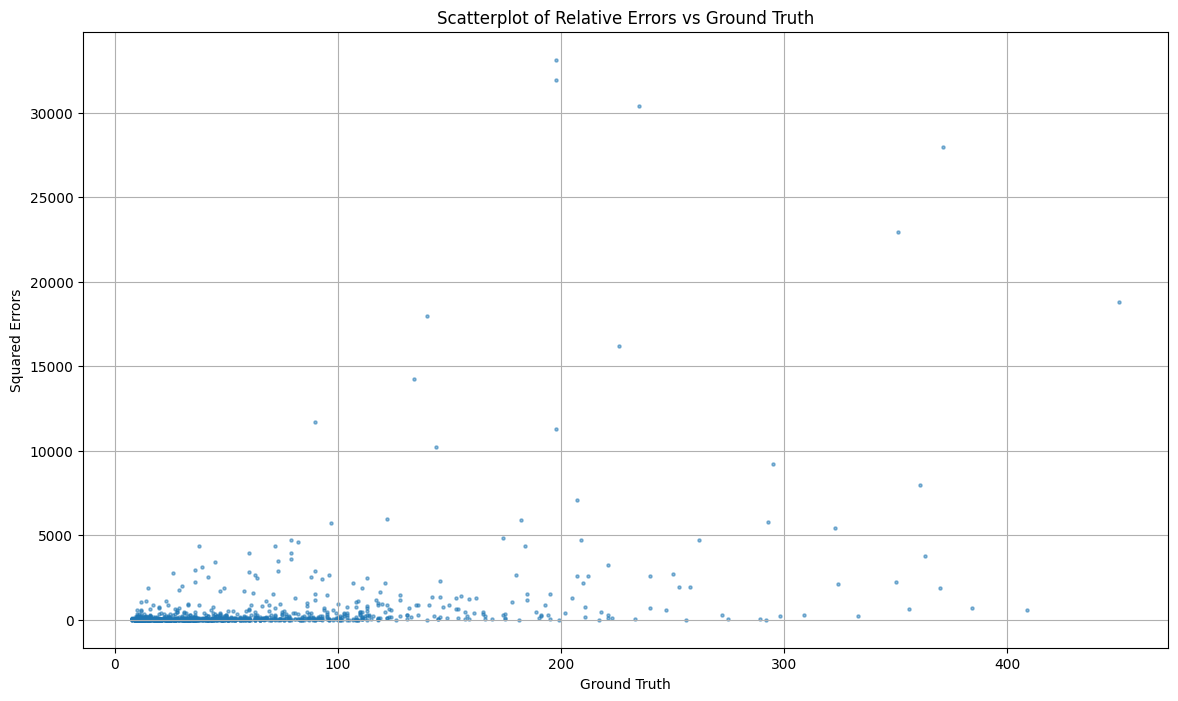

In [16]:
plt.figure(figsize=(14, 8))
plt.scatter(gt_counts, squared_errors_copy, alpha=0.5, s=5)
x_interval = 500
y_interval = 60000
#plt.xticks(range(0, max(gt_counts)+x_interval, x_interval))
#plt.yticks([i * y_interval for i in range(int(max(relative_errors)//y_interval) + 2)])
plt.xlabel('Ground Truth')
plt.ylabel('Squared Errors')
plt.title('Scatterplot of Relative Errors vs Ground Truth')
plt.grid(True)
plt.show()

### Inference test with all Test Classes as textual prompt

In [8]:
img_directory = './data/FSC/images_384_VarV2'
cnt_errors = 0

for img_filename in tqdm.tqdm(split_images["test"]):
    
    img = Image.open(os.path.join(img_directory, img_filename))
    img.load()
    img_array = np.array(img)
    
    for class_name in split_classes["test"]:
        prompt = class_name
        _, pred_cnt= infer(img_array, prompt)
        df.at[img_filename, class_name] = pred_cnt
        
        if class_name == img_classes[img_filename]:
            cnt_error = abs(pred_cnt - gt_counts_dict[img_filename])
            cnt_errors += cnt_error

mae = cnt_errors/len(split_images["test"])
print("Mean Absolute Error (MAE):", mae)

  0%|          | 0/1190 [00:01<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
df

In [ ]:
selected_img = 337
img_filename = df.index.tolist()[selected_img]
example_img_dist = df.iloc[selected_img]
img_gt_class = img_classes[img_filename]

example_img_dist = example_img_dist.sort_values(ascending=False)

for i, class_name in enumerate(example_img_dist.index):
    if class_name == img_gt_class:
        img_gt_class_idx = i
        break

plt.figure(figsize=(12, 6))
colors = ['skyblue' if i != img_gt_class_idx else 'orange' for i in range(len(example_img_dist))]
plt.bar(example_img_dist.index, example_img_dist.values, width=0.7, color=colors)
plt.title(f'Boxplot of the image {img_filename}')
plt.xlabel('Class Names')
plt.ylabel('Prediction')
for i in range(len(example_img_dist.index)):
    plt.text(i, example_img_dist.values[i], round(example_img_dist.values[i]))
plt.xticks(rotation=90)
plt.grid(True, axis='y')
plt.show()

In [ ]:
# saving Dataframe to .csv file
df.to_csv('Inference_Test1_CLIP-Count.csv')